In [1]:
# widgets imports
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, IntSlider
from IPython.display import display, clear_output

In [2]:
# math and data manipulation
import numpy as np
import sympy as sp
import pandas as pd

In [3]:
# scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [4]:
# utilities
import shutil
import os


In [5]:
# scipy imports
from scipy.optimize import curve_fit
from scipy.special import sph_harm
from scipy.fft import fft, ifft, fftfreq

In [6]:
# matplotlib imports
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Arc
from matplotlib.ticker import MultipleLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.widgets import Slider

In [7]:
# compchem imports
import psi4
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import py3Dmol
import fortecubeview

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display, clear_output

def plot_fid(B0=1.0, decay_rate=0.5, time=0.0):
    """
    Plot the macroscopic magnetization and FID signal.
    
    Parameters:
    B0 : float
        Strength of the magnetic field (relative scale)
    decay_rate : float
        Rate of decay for the FID signal
    time : float
        Current time (0-1 represents the duration of visualization)
    time_points : int
        Number of time points to display in the FID
    """
    time_points=50
    # Clear previous plot
    clear_output(wait=True)
    
    # Create figure with custom layout
    fig = plt.figure(figsize=(7, 6))
    # Create a gridspec for more control over subplot sizes
    gs = fig.add_gridspec(2, 3, height_ratios=[2, 1], width_ratios=[1, 0.5,1])
    
    # 3D axis for magnetization (top left)
    ax1 = fig.add_subplot(gs[0, 0], projection='3d')
    # Text box for equations (top right)
    ax_text = fig.add_subplot(gs[0, -1])
    ax_text.axis('off')  # Hide axes
    # 2D axis for FID (bottom, spanning both columns)
    ax2 = fig.add_subplot(gs[1, :])
    
    # Set up the magnetization plot
    ax1.set_xlim(-1.2, 1.2)
    ax1.set_ylim(-1.2, 1.2)
    ax1.set_zlim(-0.2, 1.2)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('Macroscopic Magnetization')
    
    # Draw B0 field vector
    ax1.quiver(0, 0, 0, 0, 0, 1.0, color='blue', arrow_length_ratio=0.1, label='B₀')
    
    # Draw detection coil area vector (A)
    ax1.quiver(0, 0, 0, 1.0, 0, 0, color='green', arrow_length_ratio=0.1, label='A (coil)')
    
    # Calculate precession
    omega = 2 * np.pi * B0  # Larmor frequency (scaled)
    current_angle = omega * time
    
    # Magnetization starts at 90° to B0 (in the y-axis)
    # The magnetization decays exponentially
    magnitude = np.exp(-decay_rate * time)
    x_position = magnitude * np.sin(np.pi/2) * np.cos(current_angle)  # sin(90°) = 1
    y_position = magnitude * np.sin(np.pi/2) * np.sin(current_angle)  # Initial position is along y
    z_position = 0  # Magnetization is in the xy plane after 90° pulse
    
    # Draw magnetization vector
    ax1.quiver(0, 0, 0, x_position, y_position, z_position, 
             color='red', arrow_length_ratio=0.1, label='M')
    
    # Draw the circular path for precession
    theta_path = np.linspace(0, 2*np.pi, 40)
    radii = np.linspace(magnitude, 1.0, 10)[::-1]  # Decreasing radii
    
    # Draw precession path with decreasing radii to show decay
    # Use fewer radii to improve performance
    radii = np.linspace(magnitude, 1.0, 4)[::-1]  # Reduced from 10 to 4 points
    
    for r in radii:
        # Use fewer points around the circle
        theta_path = np.linspace(0, 2*np.pi, 20)  # Reduced from 40 to 20 points
        x_path = r * np.cos(theta_path)
        y_path = r * np.sin(theta_path)
        z_path = np.zeros_like(theta_path)
        alpha = 0.1 + 0.4 * (r/1.0)  # Fade out for smaller radii
        ax1.plot(x_path, y_path, z_path, 'b--', alpha=alpha)
    
    # Add legend
    ax1.legend(loc='upper right')
    
    # Calculate FID signal
    # FID is proportional to derivative of the x-component of magnetization
    # When M·A is maximum, derivative is zero; when M·A is zero, derivative is maximum
    t_array = np.linspace(0, 3, time_points)  # Extended time range to show full decay
    
    # Magnetic flux through coil is proportional to cos(omega * t)
    # Derivative of cos is -sin, so FID is proportional to sin(omega * t)
    fid_signal = np.exp(-decay_rate * t_array) * np.sin(omega * t_array)
    
    # Convert the current time to an index in the t_array
    current_index = min(int(time * (time_points - 1) / 3), time_points - 1)  # Adjusted for new time range
    
    # Plot FID signal
    ax2.set_xlim(0, 3)  # Extended time range to show full decay
    ax2.set_ylim(-1.1, 1.1)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Voltage')
    ax2.set_title('Free Induction Decay (FID)')
    
    # Plot the FID signal as discrete points
    colors = ['black'] * time_points
    colors[current_index] = 'red'
    
    # Plot as bars with adjusted width for the extended time range
    ax2.bar(t_array, fid_signal, width=2.4/time_points, color=colors, alpha=0.7)
    
    # Add annotations
    ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    ax2.grid(True, alpha=0.3)
    
    # Add formulas to text box
    formula_text = (
        f"$\\omega_0 = \\gamma B_0 = {B0:.1f}$\n\n"
        f"$\\Phi = M \\cdot A = M_x$\n\n"
        f"$V_{{\mathrm{{induced}}}} = -\\frac{{d\\Phi}}{{dt}}$\n\n"
        f"$= -\\frac{{d(M_x)}}{{dt}}$\n\n"
        f"$\\propto e^{{-{decay_rate:.2f}t}} \\sin(\\omega_0 t)$"
    )
    ax_text.text(0.1, 0.5, formula_text, fontsize=12, 
                 bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
                 verticalalignment='center')
    
    plt.tight_layout()
    plt.show()


In [9]:
# Use widgets.interact to create the interactive visualization
widgets.interact(
    plot_fid,
    B0=(0.2, 2.0, 0.2),        # Controls Larmor frequency
    decay_rate=(0.1, 2.0, 0.1), # Controls decay rate (default 2.0)
    time=(0, 3, 0.05),      # Current time (extended range)
);


interactive(children=(FloatSlider(value=1.0, description='B0', max=2.0, min=0.2, step=0.2), FloatSlider(value=…

In [10]:
def xyz_from_smiles(smiles_string):
    rdkit_molecule = Chem.MolFromSmiles(smiles_string)
    rdkit_molecule = Chem.AddHs(rdkit_molecule)
    result = AllChem.EmbedMolecule(rdkit_molecule, randomSeed=42)
    if result != 0:
        raise ValueError("Embedding failed for the molecule")
    result = AllChem.MMFFOptimizeMolecule(rdkit_molecule)
    
    if result != 0:
        raise ValueError("Optimization failed for the molecule")
    
    xyz = Chem.MolToXYZBlock(rdkit_molecule)
    return xyz

In [11]:
def show_molecule(smiles_string):
    xyz = xyz_from_smiles(smiles_string)
    view = py3Dmol.view(width=400,height=400)
    view.addModel(xyz,'xyz')
    view.setStyle({'sphere':{'radius' : 0.3}, 'stick' : {'radius': 0.2}})
    view.setStyle({'element': 'H'}, {'sphere': {'radius': 0.3, 'color': 'white'}})
    view.zoomTo()
    view.show()

In [12]:
show_molecule('C1=CC=CC=C1')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [13]:
def create_psi4_molecule(smiles_string):
    '''
    INPUT:
    xyz format molecule coordinates
    OUTPUT:
    psi4-compatible molecular geometry object
    '''
    xyz_block = xyz_from_smiles(smiles_string)
    xyz_lines = xyz_block.split('\n')
    psi_coords = "\n".join(["0 1"] + xyz_lines[2:])
    psi4_molecule = psi4.geometry(psi_coords)
    return psi4_molecule

In [14]:
octatetraene = 'C=CC=CC=CC=C'
psi4_mol = create_psi4_molecule(octatetraene)
psi4.set_output_file('output.dat',False)
psi4.set_memory('1 GB')
my_theory = 'SCF/STO-3G'
energy, wfn = psi4.energy(my_theory,return_wfn=True,molecule=psi4_mol)

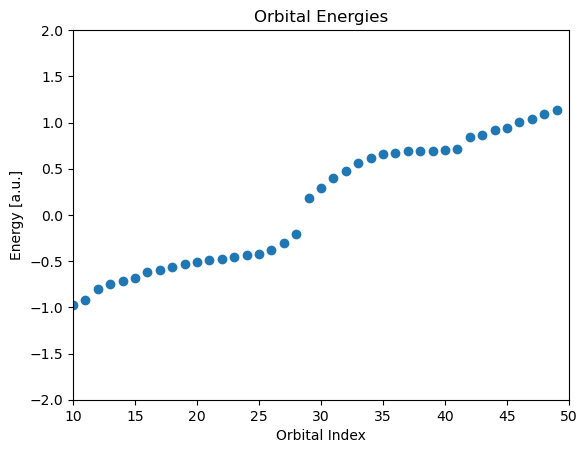

In [15]:
plt.scatter(range(len(wfn.epsilon_a().np)),wfn.epsilon_a().np)
plt.title('Orbital Energies')
plt.ylabel('Energy [a.u.]')
plt.xlabel('Orbital Index')
plt.xlim(10,50)
plt.ylim(-2,2) #Try visualizing the plot with and without these limits.
plt.show()

In [18]:
os.mkdir('cubes')
psi4.set_options({
    'CUBEPROP_TASKS':  ['orbitals'],
    'CUBEPROP_FILEPATH': 'cubes',
    'CUBEPROP_ORBITALS' : list(range(25,35))
})
psi4.cubeprop(wfn)

In [19]:
view = fortecubeview.plot('cubes',colorscheme='wow')

CubeViewer: listing cube files from the directory cubes
Reading 10 cube files


HTML(value='\n        <style>\n           .jupyter-widgets-output-area .output_scroll {\n                heigh…

interactive(children=(Select(description='Cube files:', options=('MO   25a (25-A)', 'MO   26a (26-A)', 'MO   2…

In [2]:
import shutil
shutil.rmtree('cubes')